In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import os
import urllib.request

In [2]:
def load_data(asset_name, tx_window, market_window, daa_window):
    if not os.path.exists('./coinmetrics'):
        os.makedirs('./coinmetrics')
    if not os.path.exists('./coinmetrics/'+asset_name+'.csv'):
        url = 'https://coinmetrics.io/data/'+asset_name+'.csv'
        urllib.request.urlretrieve(url, './coinmetrics/'+asset_name+'.csv')    
    data = pd.read_csv("./coinmetrics/"+asset_name+".csv", parse_dates=True, index_col=0)
    headers = list(data.columns[1:])
    headers.append("dummy")
    data.columns = headers
    data.drop("dummy", axis=1, inplace=True)
    # For BTC, only DAA are get from another source
    if asset_name=="btc":
        if not os.path.exists('./blockchain_info'):
            os.makedirs('./blockchain_info')
        if not os.path.exists('./coinmetrics/btc.csv'):            
            url = 'https://api.blockchain.info/charts/n-unique-addresses?timespan=5years&format=csv'            
            urllib.request.urlretrieve(url, './blockchain_info/'+asset_name+'.csv') 
        btc_info = pd.read_csv('blockchain_info/'+asset_name+'.csv', parse_dates=True, index_col=0)
        btc_info = btc_info.loc[(btc_info!=0).any(axis=1)]
        intersection_idx  = btc_info.index.intersection(data.index)
        data = data.loc[intersection_idx]
        data["activeAddresses"] = btc_info.loc[intersection_idx]
        data["activeAddresses"] = data["activeAddresses"].ffill()
        data["activeAddresses"] = data["activeAddresses"].bfill()
    data["ma_tx"] = data["txVolume(USD)"].rolling(center=False,window=tx_window).mean()
    data["ma_market"] = data["marketcap(USD)"].rolling(center=False,window=market_window).mean()
    data["log_nv_actual"] = np.log(data["marketcap(USD)"])
    data["daa2"] = (data["activeAddresses"]**2).rolling(center=False,window=daa_window).mean()
    data["daalndaa"] = (data["activeAddresses"]*np.log(data["activeAddresses"])).rolling(center=False,window=daa_window).mean()
    data["nvt"] = data["ma_market"] / data["ma_tx"]
    data["log_p"] = np.log(data["price(USD)"])
    data["log_nvt"] = np.log(data["nvt"])
    data.name = asset_name
    return data

def plot(data, color):
    plt.xlabel('Date')
    plt.ylabel('Value')
    data.plot(color=color, legend=True)
    plt.subplots_adjust(hspace=0.7, wspace=0.2)
    plt.grid(alpha=0.6, which = 'major')
    
def plot_signal(data):
    plt.figure(num=1, figsize=(13, 8))
    plot(data["log_p"], "red")
    plot(data["nvt"], "blue")
    plot(data["ma_tx"]/(10**9), "green")
    plt.title("Value")
    plt.show()

## Two laws are better than one: Upper and lower bounds for log(NV)

In [3]:
def get_series_values():
    index = asset["log_nv_actual"][start:].index
    s = asset["log_nv_actual"].loc[index]
    up = np.log(asset["activeAddresses"]**2).loc[index].rolling(window).mean().dropna()
    lo = np.log(asset["activeAddresses"]*np.log(asset["activeAddresses"])).loc[index].rolling(window).mean().dropna()    
    new_index = up.index
    s = s[new_index].values
    up = up[new_index].values
    lo = lo[new_index].values
    return s, up, lo

def loss_up(x):
    s, up, lo = get_series_values()
    y = x[0]+x[1]*up-s
    return np.sum(y**2)

def loss_lo(x):
    s, up, lo = get_series_values()
    y = s- (x[0]+x[1]*lo)
    return np.sum(y**2)

def bounds(asset, start, window):
    
    x0 = [0.1,0.1,1]
    s, up, lo = get_series_values()
    
    # eq means == 0, ineq means > 0
    cons_up = ({'type': 'ineq', 'fun': lambda x:  x[2]*np.min(x[0]+x[1]*up-s)})
    cons_lo = ({'type': 'ineq', 'fun': lambda x:  x[2]*np.min(s-(x[0]+x[1]*lo))})
    bnds = ((None, None), (None, None), (1, None))
    
    res_up = minimize(loss_up, x0, constraints=cons_up, bounds=bnds, options={'maxiter': 1e4, 'disp': True})
    a1, b1, l1 = res_up.x
    print("lamda up:", l1, "constraint up:", l1*np.min(a1+b1*up-s))
    
    res_lo = minimize(loss_lo, x0, constraints=cons_lo, bounds=bnds, options={'maxiter': 1e4, 'disp': True})
    a2, b2, l2 = res_lo.x
    print("lamda low:", l2, "constraint low:", l2*np.min(s-(a2+b2*lo)))    
    
    NV_upper = a1 + b1*np.log(asset["activeAddresses"]**2)[start:].rolling(window).mean().dropna()
    NV_upper.dropna(inplace=True)
    NV_upper.name = "log NV upper"
    NV_lower = a2 + b2*np.log(asset["activeAddresses"]*np.log(asset["activeAddresses"]))[start:].rolling(window).mean().dropna()
    NV_lower.name = "log NV lower"
    NV_lower.dropna(inplace=True)
    return NV_upper, NV_lower

def plot_bounds(asset, NV_upper, NV_lower, c):
    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_xlabel('Date', fontsize='large')
    upper = ax.plot(NV_upper, color='#3D9127')
    lower = ax.plot(NV_lower, color="red")#color='#006e44')
    net = ax.plot(asset["log_nv_actual"].loc[NV_upper.index], color="blue")#color='#006e44')
    daa = ax.plot(np.log(asset["activeAddresses"].loc[NV_upper.index])+c, color='#000000')
    ax.fill_between(NV_lower.index, NV_lower, asset["log_nv_actual"].loc[NV_upper.index],facecolor='#3c9824', interpolate=True)
    ax.fill_between(NV_lower.index, asset["log_nv_actual"].loc[NV_upper.index], NV_upper, facecolor='#58d039', interpolate=True)
    ax.set_xlim(left=NV_lower.index[0], right=NV_lower.index[-1])
    plt.title("Upper and lower bounds for log(NV)", fontsize=18)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, ["Upper NV Bound: Log(Metcalfe's law (NV ~ n^2))",
                         "Lower NV Bound: Log(Odlyzko's law (NV ~ n*log(n)))",
                         "Log(NV actual)",
                         "Log (Daily active addresses) + C"], fontsize='large')
    plt.grid(color='grey', linestyle='-', linewidth=0.2)
    plt.show()
    
def calculate_nv_fundamental(NV_upper, NV_lower):
    NV_fundamental = (NV_upper + NV_lower)/2
    NV_fundamental.name = "log NV fundamental"
    return NV_fundamental
    
def plot_actual_and_estimated(asset, NV_upper, NV_lower, NV_fundamental):
    fig, ax = plt.subplots(figsize=(10,8))
    ax.set_xlabel('Date', fontsize='large')
    ax.set_ylabel('NV', fontsize='large')
    ax.plot(NV_fundamental, color="orange")
    ax.plot(asset["log_nv_actual"], color="red")
    ax.set_xlim(left=NV_fundamental.index[0], right=NV_fundamental.index[-1])
    plt.title("Actual and estimated Network Value", fontsize=18)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, ["Log(NV fundamental)","Log(NV actual)"], fontsize='large')
    plt.grid(color='grey', linestyle='-', linewidth=0.2)
    plt.show()

def calculate_nvm_norm(asset, NV_upper, NV_lower, NV_fundamental):
    nvm = asset["log_nv_actual"]-NV_fundamental
    nvm.name = "NVM"
    den = (NV_upper-NV_lower)/2
    nvm_normalized = nvm/den
    nvm_normalized.dropna(inplace=True)
    nvm_normalized.name = "NVM normalized"
    return nvm_normalized

def plot_actual_and_nvm(asset, nvm_normalized):
    
    fig, ax1 = plt.subplots(figsize=(10,8))

    ax1.plot(asset["log_nv_actual"], color="black")
    ax1.set_xlabel('Date', fontsize='large')
    ax1.set_ylabel('Log (NV)', color='black', fontsize='large')
    ax1.tick_params('y', colors='black')

    handles, labels = ax1.get_legend_handles_labels()
    plt.legend(handles, ["Log(NV actual)"], loc='upper right', fontsize='large')

    ax2 = ax1.twinx()
    ax2.plot(nvm_normalized, color=(148./255, 67./255, 168./255))
    ax2.set_ylabel('NVM', color=(148./255, 67./255, 168./255), fontsize='large')
    ax2.tick_params('y', colors='black')

    handles, labels = ax2.get_legend_handles_labels()
    plt.legend(handles, ["NVM normalized"], loc='upper left', fontsize='large')
    
    x = asset.index
    y_0 = np.zeros(asset.shape[0])
    ax2.plot(x, y_0, color="black")

    y_upper = np.ones(asset.shape[0])*10
    y_pos = np.ones(asset.shape[0])*0.25
    y_neg = np.ones(asset.shape[0])*-0.25
    y_lower = np.ones(asset.shape[0])*-10
    ax2.fill_between(x, y_pos, y_upper, where=y_upper >= y_pos, facecolor=(222./255, 13./255, 13./255, 0.4), interpolate=True)
    ax2.fill_between(x, y_lower, y_neg, where=y_lower <= y_neg, facecolor=(62./255, 222./255, 13./255, 0.4), interpolate=True)
    ax1.set_xlim(left=nvm_normalized.index[0], right=nvm_normalized.index[-1])
    ax2.set_xlim(left=nvm_normalized.index[0], right=nvm_normalized.index[-1])
    ax2.set_ylim(-1.3, 1.3)

    plt.title("Network Value and NVM ratio", fontsize=18)
    fig.tight_layout()
    ax1.grid(color='grey', linestyle='-', linewidth=0.2)
    plt.show()

In [4]:
def plot_params(asset):
    # constants empirically chosen to have the narrowest corridor possible that still covers all the movements of Network Value
    if asset.name=="eth":
        #a1, b1, a2, b2, c = 8.5, 0.7, 7, 1.1, 9
        daa_displacement = 9
        start = 0
    elif asset.name=="zec":
        #a1, b1, a2, b2, c = 5.7, 0.7, -15, 2.55, 5
        daa_displacement = 5
        start = 0
    elif asset.name=="xrp":
        #a1, b1, a2, b2, c = 11, 0.8, 12, 0.8, 4
        daa_displacement = 4
        start = pd.to_datetime("01/01/2015")
    elif asset.name=="btc":
        #a1, b1, a2, b2, c = 0.8, 0.97, 2.3, 1.3, 6
        daa_displacement = 6
        start = 0
    elif asset.name=="dash":
        start = 0
        daa_displacement = 4
    elif asset.name=="etc":
        start = 0
        daa_displacement = 4
    elif asset.name=="neo":
        start = 0
        daa_displacement = 4
    elif asset.name=="pay":
        start = 0
        daa_displacement = 4
    elif asset.name=="gnt":
        start = 0
        daa_displacement = 4
    elif asset.name=="xem":
        start = 0
        daa_displacement = 4
    elif asset.name=="xlm":
        start = 0
        daa_displacement = 4
    elif asset.name=="zil":
        start = 0
        daa_displacement = 8
    elif asset.name=="trx":
        start = pd.to_datetime("12/01/2017")
        daa_displacement = 8
    else:
        start = 0
        daa_displacement = 0
    return start, daa_displacement

def analyze(asset):
    NV_upper, NV_lower = bounds(asset, start, window)
    plot_bounds(asset, NV_upper, NV_lower, daa_displacement)
    NV_fundamental = calculate_nv_fundamental(NV_upper, NV_lower)
    plot_actual_and_estimated(asset, NV_upper, NV_lower, NV_fundamental)
    nvm_normalized = calculate_nvm_norm(asset, NV_upper, NV_lower, NV_fundamental)
    plot_actual_and_nvm(asset, nvm_normalized)

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 8296.548561889575
            Iterations: 21
            Function evaluations: 128
            Gradient evaluations: 17
lamda up: 1.0000042572820687 constraint up: -0.0011935750509970754
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 4150.259305862479
            Iterations: 22
            Function evaluations: 166
            Gradient evaluations: 21
lamda low: 1.1568172797671694 constraint low: -8.360266463907829e-09


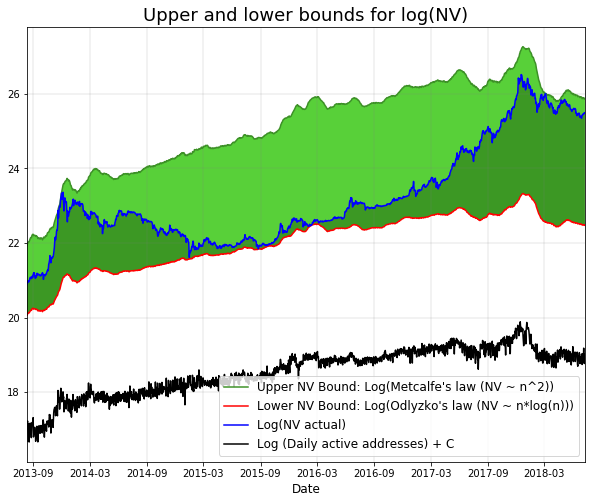

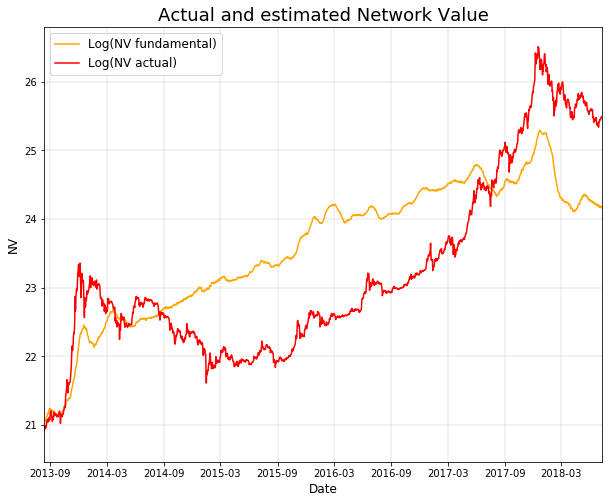

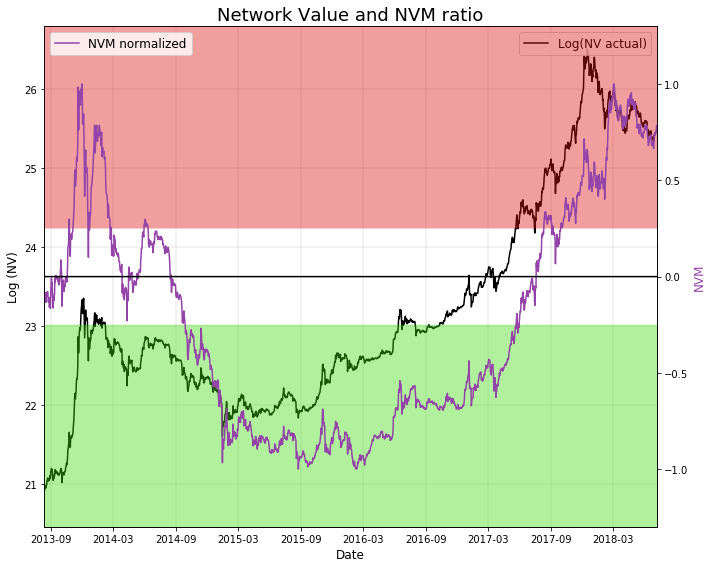

In [5]:
asset_name= "btc"
tx_window=90
market_window=1
daa_window=30
asset = load_data(asset_name, tx_window, market_window, daa_window)
start, daa_displacement = plot_params(asset)
window = 30
analyze(asset)